<a href="https://colab.research.google.com/github/hagapova/cpp-projects/blob/master/final_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Object detection

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>


This Colab demonstrates use of a TF-Hub module trained to perform object detection.

## Imports and function definitions


In [0]:
#@title Imports and function definitions

# For running inference on the TF-Hub module.
import tensorflow as tf
import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

W0322 11:30:52.771902 140482438064000 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


The following GPU devices are available: /device:GPU:0


## Example use

### Helper functions for downloading images and for visualization.

Visualization code adapted from [TF object detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py) for the simplest required functionality.

In [0]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()
    
  staticobjects = ["Window", "Umbrella", "Building", "House", "Tree", "Skyscraper",
                   "Furniture", "Traffic light", "Street light", "Door",
                   "Tower", "Billboard"]
  
  allpoints = []
  
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i].tolist())
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      if class_names[i].decode("ascii") in staticobjects:
        allpoints.append([xmin, ymin])
        allpoints.append([xmax, ymax])
        allpoints.append([xmin, ymax])
        allpoints.append([xmax, ymin])
        
        draw_bounding_box_on_image(
            image_pil,
            ymin,
            xmin,
            ymax,
            xmax,
            color,
            font,
            display_str_list=[display_str])
        np.copyto(image, np.array(image_pil))
  outputuple = (image, allpoints)
  return outputuple

## Apply module

Load a public image from Open Images v4, save locally, and display.

Image downloaded to /tmp/tmppm7xaczl.jpg.


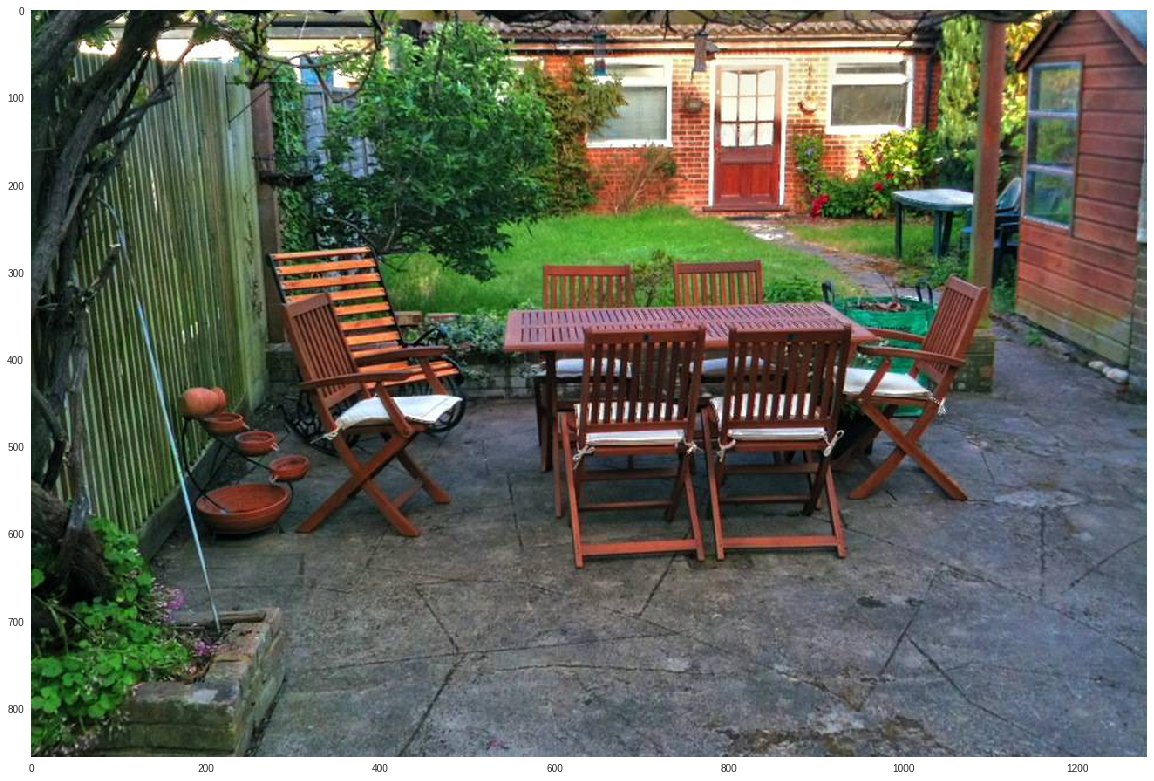

In [0]:
image_url = "https://farm1.staticflickr.com/4032/4653948754_c0d768086b_o.jpg"  #@param
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

Pick an object detection module and apply on the downloaded image. Modules:
* **FasterRCNN+InceptionResNet V2**: high accuracy,
* **ssd+mobilenet V2**: small and fast.

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0322 11:31:44.144870 140482438064000 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0322 11:32:05.287832 140482438064000 saver.py:1483] Saver not created because there are no variables in the graph to restore


Found 100 objects.


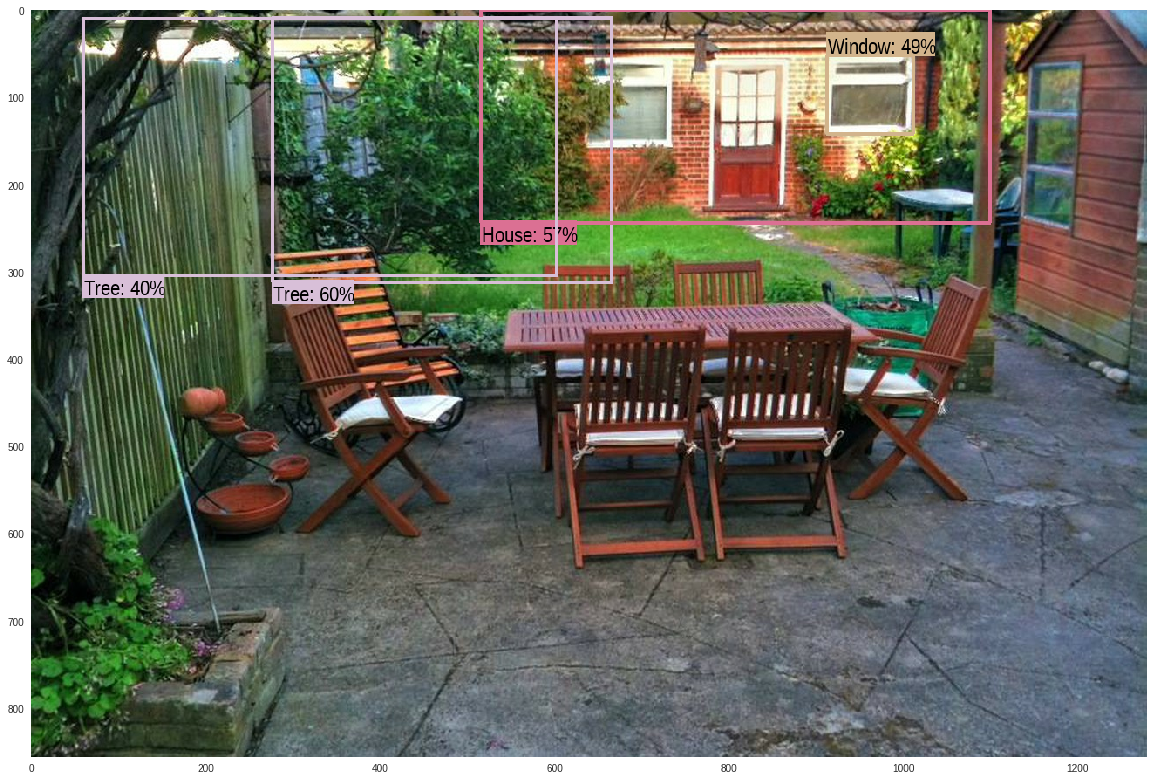

In [0]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

with tf.Graph().as_default():
  detector = hub.Module(module_handle)
  image_string_placeholder = tf.placeholder(tf.string)
  decoded_image = tf.image.decode_jpeg(image_string_placeholder)
  # Module accepts as input tensors of shape [1, height, width, 3], i.e. batch
  # of size 1 and type tf.float32.
  decoded_image_float = tf.image.convert_image_dtype(
      image=decoded_image, dtype=tf.float32)
  module_input = tf.expand_dims(decoded_image_float, 0)
  result = detector(module_input, as_dict=True)
  init_ops = [tf.global_variables_initializer(), tf.tables_initializer()]

  session = tf.Session()
  session.run(init_ops)

  # Load the downloaded and resized image and feed into the graph.
  with tf.gfile.Open(downloaded_image_path, "rb") as binfile:
    image_string = binfile.read()

  result_out, image_out = session.run(
      [result, decoded_image],
      feed_dict={image_string_placeholder: image_string})
  print("Found %d objects." % len(result_out["detection_scores"]))

image_with_boxes = draw_boxes(
    np.array(image_out), result_out["detection_boxes"],
    result_out["detection_class_entities"], result_out["detection_scores"])[0]

display_image(image_with_boxes)

### More images
Perform inference on some additional images with time tracking.


Image downloaded to /tmp/tmpklbhabjd.jpg.
Found 100 objects.
Inference took 4.80 seconds.
Image downloaded to /tmp/tmpkwaiuw4o.jpg.
Found 100 objects.
Inference took 1.90 seconds.
Image downloaded to /tmp/tmpf627aq6n.jpg.
Found 100 objects.
Inference took 1.95 seconds.
Image downloaded to /tmp/tmpgebfdab_.jpg.
Found 100 objects.
Inference took 1.91 seconds.
Image downloaded to /tmp/tmpu1dwduw9.jpg.
Found 100 objects.
Inference took 1.93 seconds.
Image downloaded to /tmp/tmpmku6n_20.jpg.
Found 100 objects.
Inference took 1.88 seconds.
Image downloaded to /tmp/tmppnqbk0ww.jpg.
Found 100 objects.
Inference took 1.89 seconds.
Image downloaded to /tmp/tmphce399a2.jpg.
Found 100 objects.
Inference took 1.91 seconds.
Image downloaded to /tmp/tmpqguhil8a.jpg.
Found 100 objects.
Inference took 1.90 seconds.
Image downloaded to /tmp/tmpluf4782k.jpg.
Found 100 objects.
Inference took 1.90 seconds.
Image downloaded to /tmp/tmpityuu4jd.jpg.
Found 100 objects.
Inference took 1.89 seconds.
Image down

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Image downloaded to /tmp/tmpi11_2wgx.jpg.
Found 100 objects.
Inference took 1.89 seconds.
Image downloaded to /tmp/tmp4wf3w7ut.jpg.
Found 100 objects.
Inference took 1.85 seconds.
Image downloaded to /tmp/tmpp41f0353.jpg.
Found 100 objects.
Inference took 1.89 seconds.
Image downloaded to /tmp/tmpu4crag2g.jpg.
Found 100 objects.
Inference took 1.92 seconds.
Image downloaded to /tmp/tmp84k5bhb2.jpg.
Found 100 objects.
Inference took 1.88 seconds.
Image downloaded to /tmp/tmpz0nmm2dh.jpg.
Found 100 objects.
Inference took 1.90 seconds.
Image downloaded to /tmp/tmp66f8j7og.jpg.
Found 100 objects.
Inference took 1.91 seconds.
Image downloaded to /tmp/tmpr8ejj8_u.jpg.
Found 100 objects.
Inference took 1.88 seconds.
Image downloaded to /tmp/tmpim36ryt9.jpg.
Found 100 objects.
Inference took 1.90 seconds.
Image downloaded to /tmp/tmp8t4u7dge.jpg.
Found 100 objects.
Inference took 1.94 seconds.
Image downloaded to /tmp/tmpnrlrirnz.jpg.
Found 100 objects.
Inference took 1.90 seconds.
Image down

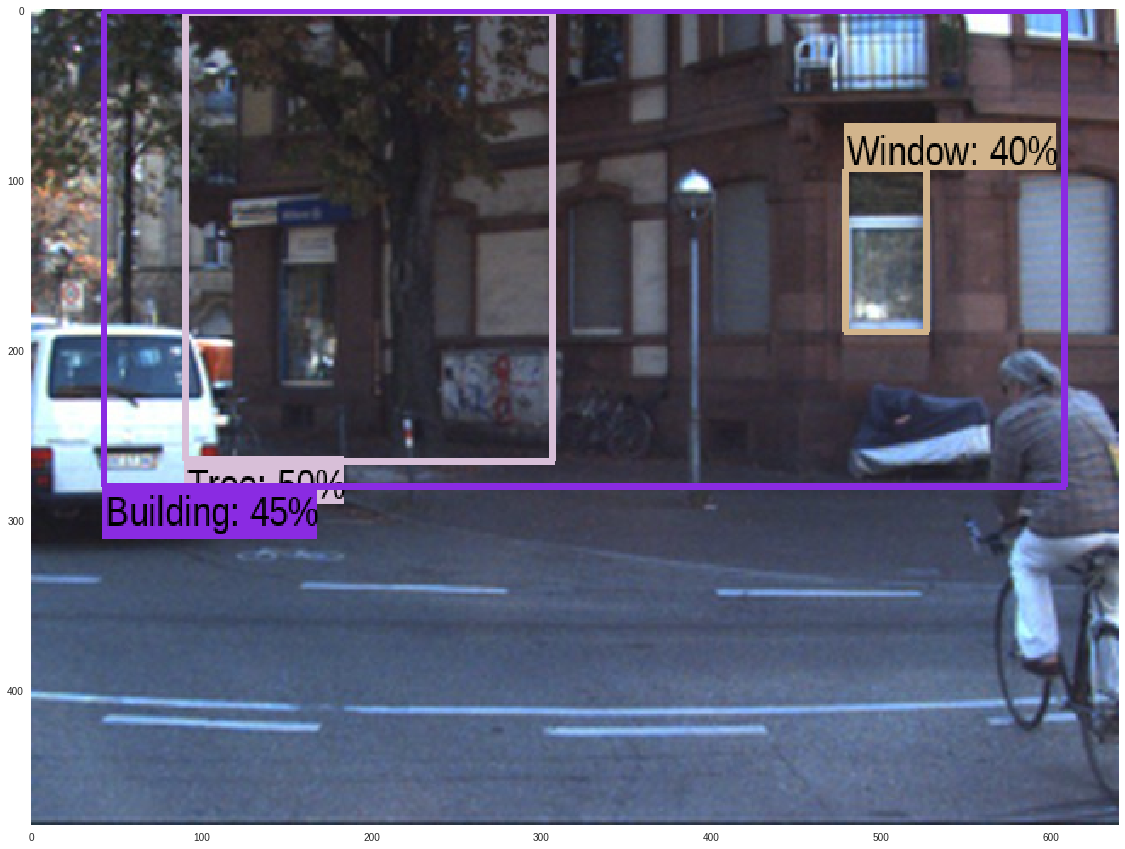

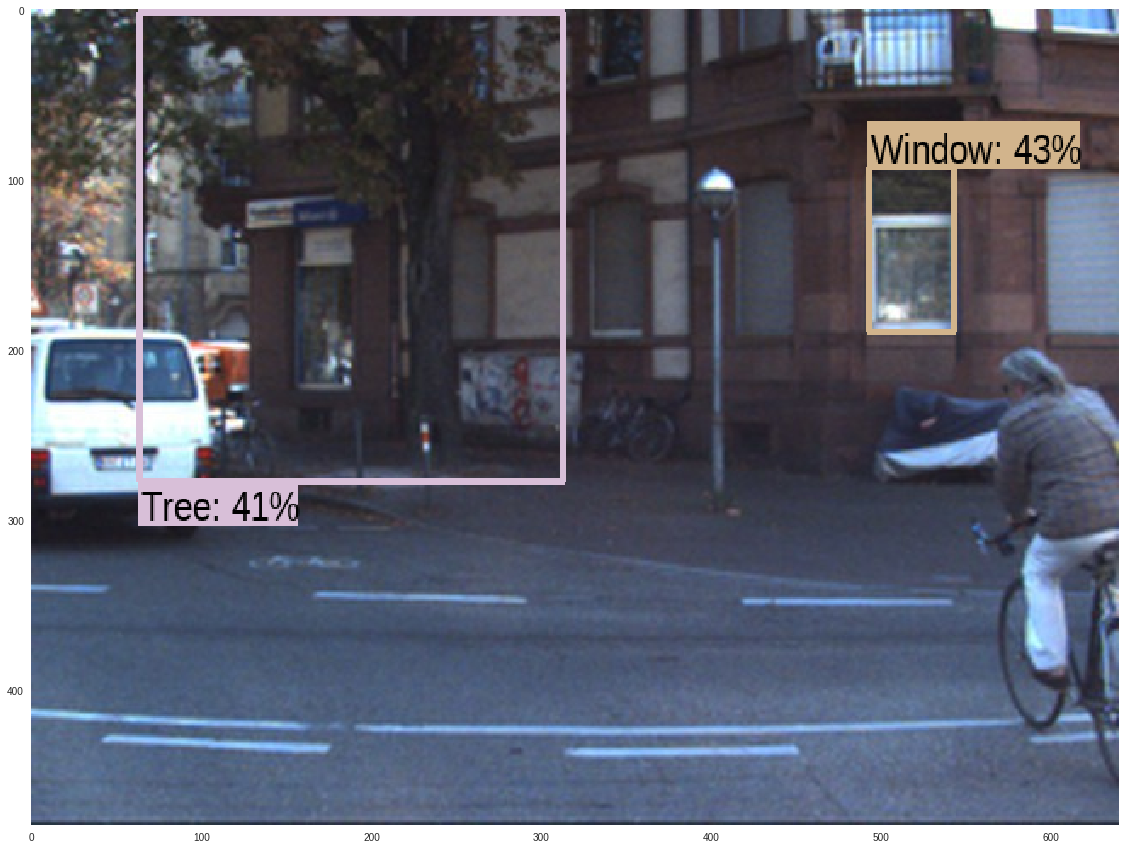

In [0]:
image_urls = ["https://i.ibb.co/1Td0St0/0000000010.png",
              "https://i.ibb.co/519bPdx/0000000011.png",
              "https://i.ibb.co/HgmdwDk/0000000012.png",
              "https://i.ibb.co/zsJV0Gk/0000000013.png",
              "https://i.ibb.co/gP354Sy/0000000014.png",
              "https://i.ibb.co/dcbkDm3/0000000015.png",
              "https://i.ibb.co/vh9Pnf9/0000000016.png",
              "https://i.ibb.co/48kYKg1/0000000017.png",
              "https://i.ibb.co/MDpLVC5/0000000018.png",
              "https://i.ibb.co/ZVF7PrM/0000000019.png",
              "https://i.ibb.co/G5SYgLP/0000000020.png",
              "https://i.ibb.co/NtB5VtX/0000000021.png",
              "https://i.ibb.co/kcDSKWJ/0000000022.png",
              "https://i.ibb.co/W62SnfW/0000000023.png",
              "https://i.ibb.co/0VW4xDg/0000000024.png",
              "https://i.ibb.co/NKcJTWK/0000000025.png",
              "https://i.ibb.co/KyGJhD4/0000000026.png",
              "https://i.ibb.co/HTVLWyy/0000000027.png",
              "https://i.ibb.co/1K2NCMC/0000000028.png",
              "https://i.ibb.co/jH4KFR8/0000000029.png",
              "https://i.ibb.co/qRSQPSg/0000000030.png",
              "https://i.ibb.co/h2q7XXg/0000000031.png",
              "https://i.ibb.co/pbVKXZp/0000000032.png",
              "https://i.ibb.co/TM9sTxM/0000000033.png",
              "https://i.ibb.co/Xb3jj55/0000000034.png",
              "https://i.ibb.co/gS3GFrr/0000000035.png",
              "https://i.ibb.co/c2HbWTx/0000000039.png",
              "https://i.ibb.co/RNPf93F/0000000040.png",
              "https://i.ibb.co/2WN77cQ/0000000042.png",
              "https://i.ibb.co/KNy0kGn/0000000044.png",
              "https://i.ibb.co/CJR3khm/0000000045.png",
              "https://i.ibb.co/5hfZGzJ/0000000046.png",
              "https://i.ibb.co/x7yN734/0000000047.png",
              "https://i.ibb.co/KqSLCQr/0000000048.png",
              "https://i.ibb.co/TbLZbS1/0000000049.png",
              "https://i.ibb.co/bbzQtDM/0000000050.png",
              "https://i.ibb.co/bX3c2XZ/0000000052.png",
              "https://i.ibb.co/ZxJs5SV/0000000053.png",
              "https://i.ibb.co/fqb3R2Z/0000000054.png",
              "https://i.ibb.co/nQKkRqj/0000000055.png",
              "https://i.ibb.co/z6yBdcQ/0000000056.png",
              "https://i.ibb.co/9cgzgV7/0000000057.png",
              "https://i.ibb.co/bH8v0qr/0000000058.png",
              "https://i.ibb.co/WgFJhy0/0000000059.png",
              "https://i.ibb.co/VV7c7K8/0000000060.png",
              "https://i.ibb.co/b5wLSLL/0000000061.png",
              "https://i.ibb.co/D7zDHRD/0000000062.png",
              "https://i.ibb.co/y8LMw3v/0000000063.png",
              "https://i.ibb.co/zJHM0mk/0000000064.png",
              "https://i.ibb.co/gJ38jYS/0000000065.png",
              "https://i.ibb.co/grGSFDJ/0000000066.png",
              "https://i.ibb.co/hDG1GCj/0000000067.png",
              "https://i.ibb.co/kxTvKFS/0000000068.png",
              "https://i.ibb.co/n1cHPJ5/0000000069.png",
              "https://i.ibb.co/hYjWNdf/0000000070.png",
              "https://i.ibb.co/dQNsY89/0000000071.png",
              "https://i.ibb.co/d6jSSJC/0000000072.png",
              "https://i.ibb.co/zxDDBQn/0000000073.png",
              "https://i.ibb.co/h8PQfLy/0000000074.png",
              "https://i.ibb.co/ZmXwsCy/0000000075.png",
              "https://i.ibb.co/ZXFFG3w/0000000076.png",
              "https://i.ibb.co/gyLwtXT/0000000077.png",
             ]

pictures = [] #массив массивов объектов, встреченных на картинках

for i in range(0, len(image_urls)):
  image_url = image_urls[i]
  image_path = download_and_resize_image(image_url, 640, 480)
  with tf.gfile.Open(image_path, "rb") as binfile:
    image_string = binfile.read()

  inference_start_time = time.clock()
  result_out, image_out = session.run(
      [result, decoded_image],
      feed_dict={image_string_placeholder: image_string})
  print("Found %d objects." % len(result_out["detection_scores"]))
  print("Inference took %.2f seconds." % (time.clock()-inference_start_time))
  
  image_with_boxes = draw_boxes(
    np.array(image_out), result_out["detection_boxes"],
    result_out["detection_class_entities"], result_out["detection_scores"])[0]
  
  #добавили массив значимых точек в массив картинок
  pictures.append(draw_boxes(
    np.array(image_out), result_out["detection_boxes"],
    result_out["detection_class_entities"], result_out["detection_scores"])[1])

  display_image(image_with_boxes)

In [0]:
import cv2
import numpy as np
import random

rmatrices = []
tvecs = []

for i in range(0, len(pictures) - 1):
  j = i + 1

  if len(pictures[i]) < len(pictures[j]):
    while len(pictures[i]) != len(pictures[j]):
      pictures[i].append([random.random(), random.random()])
  if len(pictures[i]) > len(pictures[j]):
    while len(pictures[i]) != len(pictures[j]):
      pictures[j].append([random.random(), random.random()])

  points1 = np.asarray(pictures[i])
  points2 = np.asarray(pictures[j])

  # матрица камеры 
  K_00 = np.array([[9.842439e+02, 0.000000e+00, 6.900000e+02],
          [0.000000e+00, 9.808141e+02, 2.331966e+02],
          [0.000000e+00, 0.000000e+00, 1.000000e+00]])

  R = np.array([])
  R1 = np.array([])
  R2 = np.array([])
  t = np.array([])

  if points1.shape == points2.shape:
    E, mask = cv2.findEssentialMat(points1, points2, K_00, cv2.RANSAC, 0.999, 1.0)
    #retval, R, t, mask = cv2.recoverPose(E, points1, points2, K_00, R, t, mask)
    R1, R2, t	=	cv2.decomposeEssentialMat(E, R1, R2, t)
    if i == 0:
      rmatrices.append(R1)
    else:
      if (np.linalg.norm(R1 - rmatrices[i-1]) >
          np.linalg.norm(R2 - rmatrices[i-1])):
        rmatrices.append(R2)
      else:
        rmatrices.append(R1)


  tvecs.append(t)

for i in range(0, len(rmatrices)):
  print(rmatrices[i])
  print("\n")
  
for i in range(0, len(tvecs)):
  print(tvecs[i])
  print("\n")

[[ 0.31569433  0.09536821  0.94405614]
 [ 0.09549444 -0.99307807  0.06838685]
 [ 0.94404338  0.06856277 -0.32261625]]


[[ 0.36172108 -0.0856549   0.9283432 ]
 [-0.13006228 -0.99066899 -0.04072781]
 [ 0.92316936 -0.10601032 -0.36948633]]


[[ 0.34708956 -0.02593996  0.93747317]
 [-0.02589098 -0.99950143 -0.01807043]
 [ 0.93747453 -0.01800004 -0.34758813]]


[[-0.36525703  0.21461292 -0.90583033]
 [ 0.21582068 -0.92702799 -0.3066603 ]
 [-0.90554334 -0.30750675  0.29228559]]


[[-0.22469355 -0.29652977 -0.9282149 ]
 [ 0.6817711  -0.72842919  0.067669  ]
 [-0.6962047  -0.6176253   0.36583877]]


[[-0.85133837 -0.52425125 -0.01958602]
 [-0.52418658  0.84853489  0.07222854]
 [-0.02124648  0.07175765 -0.99719578]]


[[-0.99476857  0.09883101  0.02584442]
 [ 0.0981491   0.85452594  0.51005114]
 [ 0.02832414  0.50991945 -0.85975572]]


[[-0.86434228  0.45948574  0.20441448]
 [ 0.45958432  0.55665639  0.69203751]
 [ 0.20419274  0.69210297 -0.69231409]]


[[-0.99646797 -0.08394793  0.00207972]
 

In [0]:
#построить траекторию (Rc + t итеративно)//сравнить с гроунд трус//

position_0 = np.zeros((3, 1))
positions = [position_0]

for i in range(0, len(rmatrices)):  
  position_iplus1 = np.dot(rmatrices[i], positions[i])
  position_iplus1 = position_iplus1 + tvecs[i]

  positions.append(position_iplus1)

for i in range(0, len(positions)):
  print(positions[i])
  print("\n")
  
#нарисовать путь по их данным из граунд трус
#прогнать побольше картинок
#прогнать картинки с поворотом чтобы увидеть изменение

[[0.]
 [0.]
 [0.]]


[[ 0.56308329]
 [ 0.1910269 ]
 [-0.80401861]]


[[ 0.0019718 ]
 [-0.01826439]
 [-0.00366299]]


[[ 0.56121016]
 [ 0.20938914]
 [-0.80026415]]


[[ 0.0015005 ]
 [-0.01859157]
 [-0.00266237]]


[[-0.55539258]
 [-0.17632118]
 [ 0.81358918]]


[[ 1.11279318]
 [ 0.39139394]
 [-1.6158905 ]]


[[-0.54722382]
 [-0.1892656 ]
 [ 0.81622378]]


[[ 1.11632402]
 [ 0.39895514]
 [-1.61159226]]


[[-1.72089296]
 [-0.55366176]
 [ 2.394931  ]]


[[ 2.27221751]
 [ 0.78995031]
 [-3.19647028]]


[[-1.70851946]
 [-0.54344376]
 [ 2.40609162]]


[[ 2.25023462]
 [ 0.79861949]
 [-3.20984649]]


[[-1.69595599]
 [-0.53936201]
 [ 2.41587903]]


[[-2.2798803 ]
 [-0.77372851]
 [ 3.19498856]]


[[-2.79331948]
 [-0.94079821]
 [ 4.03949829]]


[[ 3.40607402]
 [ 1.12689525]
 [-4.80987136]]


[[ 2.80473473]
 [ 0.9632656 ]
 [-4.02626128]]


[[-2.26372945]
 [-0.7713692 ]
 [ 3.20698126]]


[[ 2.80290714]
 [ 0.95659774]
 [-4.02912333]]


[[-2.26398977]
 [-0.77081353]
 [ 3.20693067]]


[[-2.80745327]
 [-0

In [0]:
positions = np.asarray(positions)
plt.xlim(-5, 5)
plt.ylim(-2, 2)
plt.gca().set_aspect('equal', adjustable='box')

plt.scatter(positions[:, 0], positions[:, 1], s = 3)

#plt.plot(positions[:, 0], positions[:, 1])

#plt.draw()

NameError: ignored

In [0]:
import math
# из матрицы поворота в эйлеровы углы, как тут: https://www.learnopencv.com/rotation-matrix-to-euler-angles/
def rotationMatrixToEulerAngles(R) :
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
     
    singular = sy < 1e-6
 
    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
 
    return np.array([x, y, z])

print(rotationMatrixToEulerAngles(R))